In this notebook we demonstrate formal hypothesis testing using the NHANES data.

It is important to note that the NHANES data are a "complex survey". The data are not an independent and representative sample from the target population. Proper analysis of complex survey data should make use of additional information about how the data were collected. Since complex survey analysis is a somewhat specialized topic, we ignore this aspect of the data here, and analyze the NHANES data as if it were an independent and identically distributed sample from a population.

In [359]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import scipy.stats.distributions as dist

In [365]:
import scipy.stats as stats
def two_proprotions_test(success_a, size_a, success_b, size_b):
    """
    A/B test for two proportions;
    given a success a trial size of group A and B compute
    its zscore and pvalue
    
    Parameters
    ----------
    success_a, success_b : int
        Number of successes in each group
        
    size_a, size_b : int
        Size, or number of observations in each group
    
    Returns
    -------
    zscore : float
        test statistic for the two proportion z-test

    pvalue : float
        p-value for the two proportion z-test
    """
    prop_a = success_a / size_a
    prop_b = success_b / size_b
    prop_pooled = (success_a + success_b) / (size_a + size_b)
    var = prop_pooled * (1 - prop_pooled) * (1 / size_a + 1 / size_b)
    zscore = np.abs(prop_b - prop_a) / np.sqrt(var)
    one_side = 1 - stats.norm(loc = 0, scale = 1).cdf(zscore)
    pvalue = one_side * 2
    return zscore, pvalue

In [371]:
def two_proprotions_confint(success_a, size_a, success_b, size_b, significance = 0.05):
    """
    A/B test for two proportions;
    given a success a trial size of group A and B compute
    its confidence interval;
    resulting confidence interval matches R's prop.test function
    
    Parameters
    ----------
    success_a, success_b : int
        Number of successes in each group
        
    size_a, size_b : int
        Size, or number of observations in each group
        
    significance : float, default 0.05
        Often denoted as alpha. Governs the chance of a false positive.
        A significance level of 0.05 means that there is a 5% chance of
        a false positive. In other words, our confidence level is
        1 - 0.05 = 0.95
        
    Returns
    -------
    prop_diff : float
        Difference between the two proportion
    
    confint : 1d ndarray
        Confidence interval of the two proportion test
    """
    prop_a = success_a / size_a
    prop_b = success_b / size_b
    var = prop_a * (1 - prop_a) / size_a + prop_b * (1 - prop_b) / size_b
    se = np.sqrt(var)
    
    # z critical value
    confidence = 1 - significance
    z = stats.norm(loc = 0, scale = 1).ppf(confidence + significance / 2)

    # standard formula for the confidence interval
    # point-estimtate +- z * standard-error
    prop_diff = prop_b - prop_a
    confint = prop_diff + np.array([-1, 1]) * z * se
    return prop_diff, confint

In [3]:
da = pd.read_csv('nhanes.csv')

da["SMQ020x"] = da.SMQ020.replace({1: "Yes", 2: "No", 7: np.nan, 9: np.nan})

In [4]:
da["SMQ020x"].head()

0    Yes
1    Yes
2    Yes
3     No
4     No
Name: SMQ020x, dtype: object

In [5]:
da["RIAGENDRx"] = da.RIAGENDR.replace({1: "Male", 2: "Female"})

da["RIAGENDRx"].head()

0      Male
1      Male
2      Male
3    Female
4    Female
Name: RIAGENDRx, dtype: object

## Hypothesis Tests for One Proportion
The most basic hypothesis test may be the one-sample test for a proportion. This test is used if we have specified a particular value as the null value for the proportion, and we wish to assess if the data are compatible with the true parameter value being equal to this specified value. One-sample tests are not used very often in practice, because it is not very common that we have a specific fixed value to use for comparison. For illustration, imagine that the rate of lifetime smoking in another country was known to be 40%, and we wished to assess whether the rate of lifetime smoking in the US were different from 40%.

In [10]:
x = da.SMQ020x.dropna() == "Yes"
p = x.mean()

In [11]:
p

0.4050655021834061

In [8]:
se = np.sqrt(.4 * (1 - .4)/ len(x))
se

0.00647467353462031

In [12]:
test_stat = (p - 0.4) / se
test_stat

0.7823563854332805

In [13]:
pvalue = 2 * dist.norm.cdf(-np.abs(test_stat))
print(test_stat, pvalue)

0.7823563854332805 0.4340051581348052


In [14]:
#alternate method
sm.stats.proportions_ztest(x.sum(),len(x),0.4)

(0.7807518954896244, 0.43494843171868214)

In [15]:
sm.stats.binom_test(x.sum(), len(x), 0.4)

0.4340360854459431

we carried out the (two-sided) one-sample test that the population proportion of smokers is 0.4, and obtain a p-value of 0.43. This indicates that the NHANES data are compatible with the proportion of (ever) smokers in the US being 40%.

## Hypothesis Tests for Two Proportions
Comparative tests tend to be used much more frequently than tests comparing one population to a fixed value. A two-sample test of proportions is used to assess whether the proportion of individuals with some trait differs between two sub-populations. For example, we can compare the smoking rates between females and males. Since smoking rates vary strongly with age, we do this in the subpopulation of people between 20 and 25 years of age. 

In [150]:
dx = da[["SMQ020x", "RIDAGEYR", "RIAGENDRx"]].dropna()
dx=dx.loc[(dx.RIDAGEYR>=20) & (dx.RIDAGEYR<=25),:]
dx.head()

,SMQ020x,RIDAGEYR,RIAGENDRx
6,Yes,22,Male
17,No,24,Female
26,Yes,22,Male
38,No,20,Female
40,Yes,24,Male


In [151]:
p = dx.groupby("RIAGENDRx")["SMQ020x"].agg([lambda z: np.mean(z == "Yes"), "size"])
p.columns = ["Smoke", "N"]
print(p)

              Smoke    N
RIAGENDRx               
Female     0.238971  272
Male       0.341270  252


In [28]:
p_comb = (dx.SMQ020x == "Yes").mean()
va = p_comb * (1 - p_comb)

se = np.sqrt(va * (1 / p.N.Female + 1 / p.N.Male))

In [29]:
(p_comb, va, se)

(0.2881679389312977, 0.2051271779033856, 0.039599757248262944)

In [30]:
test_stat = (p.Smoke.Female - p.Smoke.Male) / se
p_value = 2 * dist.norm.cdf(-np.abs(test_stat))
(test_stat, p_value)

(-2.5833303066279414, 0.009785159057508375)

We find that the smoking rate for men is around 10 percentage points greater than the smoking rate for females, and this difference is statistically significant (the p-value is around 0.01).

In [31]:
#alternate method
dx_females = dx.loc[dx.RIAGENDRx == "Female", "SMQ020x"].replace({"Yes": 1, "No": 0})
dx_females

17      0
38      0
46      0
69      1
102     1
       ..
5622    0
5649    0
5678    1
5707    0
5734    0
Name: SMQ020x, Length: 272, dtype: int64

In [32]:
dx_males = dx.loc[dx.RIAGENDRx == "Male", "SMQ020x"].replace({"Yes": 1, "No": 0})
dx_males

6       1
26      1
40      1
48      0
96      0
       ..
5602    0
5667    1
5688    0
5701    0
5729    0
Name: SMQ020x, Length: 252, dtype: int64

In [33]:
sm.stats.ttest_ind(dx_females, dx_males)

(-2.5949731446269344, 0.00972590232121254, 522.0)

## Hypothesis Tests One Population Means
Tests of means are similar in many ways to tests of proportions. Just as with proportions, for comparing means there are one and two-sample tests, z-tests and t-tests, and one-sided and two-sided tests. As with tests of proportions, one-sample tests of means are not very common, but we illustrate a one sample test in the cell below. We compare systolic blood pressure to the fixed value 120 (which is the lower threshold for "pre-hypertension"), and find that the mean is significantly different from 120 (the point estimate of the mean is 126).

In [34]:
dx = da[["BPXSY1", "RIDAGEYR", "RIAGENDRx"]].dropna()
dx = dx.loc[(dx.RIDAGEYR >= 40) & (dx.RIDAGEYR <= 50) & (dx.RIAGENDRx == "Male"), :]
dx

,BPXSY1,RIDAGEYR,RIAGENDRx
10,144.0,46,Male
11,116.0,45,Male
20,110.0,49,Male
42,128.0,42,Male
51,118.0,50,Male
...,...,...,...
5680,134.0,50,Male
5690,138.0,48,Male
5693,96.0,41,Male
5713,116.0,43,Male


In [35]:
print(dx.BPXSY1.mean())

125.86698337292161


In [37]:
sm.stats.ztest(dx.BPXSY1,value=120)

(7.469764137102597, 8.033869113167905e-14)

with 95% confidence, we can say that the mean BP of all males between age 40 and 50 is different from 120

## Hypothesis Tests Two Population Means
In the cell below, we carry out a formal test of the null hypothesis that the mean blood pressure for women between the ages of 50 and 60 is equal to the mean blood pressure of men between the ages of 50 and 60.

There are a number of different variants on the two-sample t-test. Two often-encountered variants are the t-test carried out using the t-distribution, and the t-test carried out using the normal approximation to the reference distribution of the test statistic, often called a z-test. Below we display results from both these testing approaches. When the sample size is large, the difference between the t-test and z-test is very small.

In [39]:
dx = da[["BPXSY1", "RIDAGEYR", "RIAGENDRx"]].dropna()
dx = dx.loc[(dx.RIDAGEYR >= 50) & (dx.RIDAGEYR <= 60), :]
dx.head()

,BPXSY1,RIDAGEYR,RIAGENDRx
1,146.0,53,Male
3,132.0,56,Female
9,178.0,56,Male
15,134.0,57,Female
19,136.0,54,Female


In [40]:
bpx_female = dx.loc[dx.RIAGENDRx=="Female", "BPXSY1"]
bpx_male = dx.loc[dx.RIAGENDRx=="Male", "BPXSY1"]
print(bpx_female.mean(), bpx_male.mean())

127.92561983471074 129.23829787234044


In [43]:
#z-test
print('z-test',sm.stats.ztest(bpx_female, bpx_male))
#t-test
print('t-test',sm.stats.ttest_ind(bpx_female, bpx_male))

z-test (-1.105435895556249, 0.2689707570859362)
t-test (-1.105435895556249, 0.26925004137768577, 952.0)


 The results indicate that while the mean systolic blood pressure for men is slightly greater than that for women (129 mm/Hg versus 128 mm/Hg), this difference is not statistically significant. FAil to reject Null Hypothesis

## Heteroscedacity
Another important aspect of two-sample mean testing is "heteroscedasticity", meaning that the variances within the two groups being compared may be different. While the goal of the test is to compare the means, the variances play an important role in calibrating the statistics (deciding how big the mean difference needs to be to be declared statisitically significant). In the NHANES data, we see that there are moderate differences between the amount of variation in BMI for females and for males, looking within 10-year age bands. In every age band, females having greater variation than males.

In [44]:
dx = da[["BMXBMI", "RIDAGEYR", "RIAGENDRx"]].dropna()
da["agegrp"] = pd.cut(da.RIDAGEYR, [18, 30, 40, 50, 60, 70, 80])
da.groupby(["agegrp", "RIAGENDRx"])["BMXBMI"].agg(np.std).unstack()

RIAGENDRx,Female,Male
agegrp,,
"(18, 30]",7.745893,6.649440
"(30, 40]",8.315608,6.622412
"(40, 50]",8.076195,6.407076
"(50, 60]",7.575848,5.914373
"(60, 70]",7.604514,5.933307
"(70, 80]",6.284968,4.974855


The standard error of the mean difference (e.g. mean female blood pressure minus mean mal blood pressure) can be estimated in at least two different ways. In the statsmodels library, these approaches are referred to as the "pooled" and the "unequal" approach to estimating the variance. If the variances are equal (i.e. there is no heteroscedasticity), then there should be little difference between the two approaches. Even in the presence of moderate heteroscedasticity, as we have here, we can see that the results for the two differences are quite similar. Below we have a loop that considers each 10-year age band and assesses the evidence for a difference in mean BMI for women and for men. The results printed in each row of output are the test-statistic and p-value.

In [45]:
for k, v in da.groupby("agegrp"):
    bmi_female = v.loc[v.RIAGENDRx=="Female", "BMXBMI"].dropna()
    bmi_female = sm.stats.DescrStatsW(bmi_female)
    bmi_male = v.loc[v.RIAGENDRx=="Male", "BMXBMI"].dropna()
    bmi_male = sm.stats.DescrStatsW(bmi_male)
    print(k)
    print("pooled: ", sm.stats.CompareMeans(bmi_female, bmi_male).ztest_ind(usevar='pooled'))
    print("unequal: ", sm.stats.CompareMeans(bmi_female, bmi_male).ztest_ind(usevar='unequal'))
    print()

(18, 30]
pooled:  (1.7026932933643388, 0.08862548061449649)
unequal:  (1.7174610823927268, 0.08589495934713022)

(30, 40]
pooled:  (1.4378280405644916, 0.1504828511464818)
unequal:  (1.4437869620833494, 0.14879891057892475)

(40, 50]
pooled:  (2.8933761158070186, 0.003811246059501354)
unequal:  (2.9678691663536725, 0.0029987194174035366)

(50, 60]
pooled:  (3.362108779981367, 0.0007734964571391746)
unequal:  (3.375494390173923, 0.0007368319423226574)

(60, 70]
pooled:  (3.6172401442432753, 0.000297761021031936)
unequal:  (3.62848309454456, 0.0002850914147149227)

(70, 80]
pooled:  (2.926729252512258, 0.0034254694144858636)
unequal:  (2.937779886769224, 0.003305716331519299)



## Paired tests
A common situation in applied research is to measure the same quantity multiple times on each unit of analysis. For example, in NHANES, systolic blood pressure is measured at least two times (sometimes there is a third measurement) on each subject. Although the measurements are repeated, there is no guarantee that the mean is the same each time, i.e. the mean blood pressure may be slightly lower on the second measurement compared to the first, since people are a bit more nervous the first time they are measured. A paired test is a modified form of mean test that can be used when we are comparing two repeated measurements on the same unit.

A paired t-test for means is equivalent to taking the difference between the first and second measurement, and using a one-sample test to compare the mean of these differences to zero. Below we see that in the entire NHANES sample, the first measurement of systolic blood pressure is on average 0.67 mm/Hg greater than the second measurement. While this difference is not large, it is strongly statistically significant. That is, there is strong evidence that the mean values for the first and second blood pressure measurement differ.

In [46]:
dx = da[["BPXSY1", "BPXSY2"]].dropna()
db = dx.BPXSY1 - dx.BPXSY2
print(db.mean())
sm.stats.ztest(db)

0.6749860309182343


(9.800634425497911, 1.1188070930963587e-22)

To probe this effect further, we can divide the population into 10 year wide age bands and also stratify by gender, then carry out the paired t-test within each of the resulting 12 strata. We see that the second systolic blood pressure measurement is always lower on average than the first. The difference is larger for older people and for males. The difference is statistically significant for females over 30, and for males over 60.


In [70]:
dx = da[["RIAGENDRx", "BPXSY1", "BPXSY2", "RIDAGEYR"]].dropna()
dx["agegrp"] = pd.cut(dx.RIDAGEYR, [18, 30, 40, 50, 60, 70, 80])
for k, g in dx.groupby(["RIAGENDRx", "agegrp"]):
    db = g.BPXSY1 - g.BPXSY2
    # print stratum definition, mean difference, sample size, test statistic, p-value
    print(k, db.mean(), db.size, sm.stats.ztest(db.values, value=0))

('Female', Interval(18, 30, closed='right')) 0.13708260105448156 569 (0.7612107360791227, 0.4465312067051751)
('Female', Interval(30, 40, closed='right')) 0.6713615023474179 426 (3.307398751951031, 0.0009416674523368051)
('Female', Interval(40, 50, closed='right')) 0.5970149253731343 469 (2.6040611621024654, 0.009212631487347644)
('Female', Interval(50, 60, closed='right')) 0.7685393258426966 445 (3.1023718750881724, 0.001919766301204196)
('Female', Interval(60, 70, closed='right')) 0.8787878787878788 396 (3.1024528501809625, 0.0019192411825181255)
('Female', Interval(70, 80, closed='right')) 1.4512820512820512 390 (5.141706875154317, 2.722536503552981e-07)
('Male', Interval(18, 30, closed='right')) 0.00390625 512 (0.01959622841647691, 0.9843654725443948)
('Male', Interval(30, 40, closed='right')) 0.46296296296296297 432 (1.9451535788714596, 0.05175649697939119)
('Male', Interval(40, 50, closed='right')) 0.17894736842105263 380 (0.7201800810138878, 0.47141412641258706)
('Male', Interva

Conducting many hypothesis tests and "cherry picking" the interesting results is usually a bad practice. Here we are doing such "multiple testing" for illustration, and acknowledge that the strongest differences may be over-stated. Nevertheless, there is a clear and consistent trend with age -- older people tend to have greater differences between their first and second blood pressure measurements than younger people. There is also a difference between the genders, with older men having a stronger difference between the first and second blood pressure measurements than older women. The gender difference for younger peple is less clear.

## Power and sample size for hypothesis tests
Like nearly any analysis with data, hypothesis tests will yield more sensitive and confident results when there are larger amounts of data. Here we will study the relationship between the sample size (amount of data), and the behavior of a hypothesis test. For illustration, we will use the paired t-test for assessing whether the first and second systolic blood pressure measurement have different means, restricting to people between 50 and 60 years of age.

The simulation below randomly subsamples sets of 100, 200, 400, and 800 people from the 50-60 year old subset of NHANES, and conducts a paired z-test on each subsample. This process is repeated 500 times for each sample size. We report the fraction of these 500 trials where the p-value was smaller than 0.05. A higher fraction of trials where p<0.05 implies that it is easier to detect a difference between the first and second blood pressure measurements. We see that this proportion (called "statistical power") is only around 0.2 when the sample size is 100, and grows to essentially 100% when the sample size is 800. Note that all of these subsamples are drawn from the same parent population, so there is no change from subsample to subsample in terms of whether the means are truly different. The only thing that changes is our evidence that the difference is real. When the sample size is small, we rarely amass such evidence.

In [71]:
all_p = []
dy = dx.loc[(dx.RIDAGEYR >= 50) & (dx.RIDAGEYR <= 60), :]
for n in 100, 200, 400, 800:
    pv = []
    for i in range(500):
        dz = dy.sample(n)
        db = dz.BPXSY1 - dz.BPXSY2
        _, p = sm.stats.ztest(db.values, value=0)
        pv.append(p)
    pv = np.asarray(pv)
    all_p.append(pv)
    print((pv <= 0.05).mean())

0.226
0.392
0.696
1.0


In the simulation code above, we saved all the p-values to the array named all_p so we can consider them further here. The histogram below shows the distribution of p-values for 500 subsamples of data of size 100. We see that there are more smaller p-values than larger ones, but not to a dramatic degree. Some of the p-values are almost 1, indicating that the subsample mean differences were almost zero in those cases.

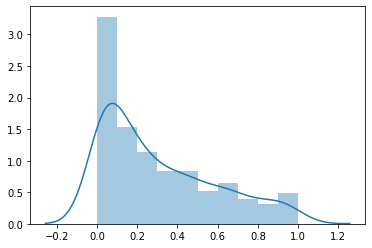

In [72]:
sns.distplot(all_p[0])

Next we inspect the distribution of p-values for subsamples of size 400. We see that the p-values are much more concentrated close to zero compared to when we had only 100 data points. If we obtain a sample of size 400 from this population, we have around a 70% chance of obtaining a p-value smaller than 0.05, and are very unlikely to obtain a p-value greater than 0.4.

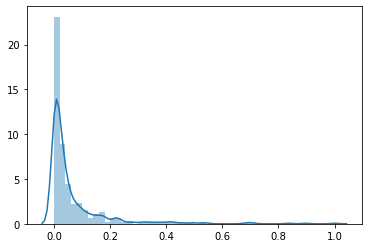

In [73]:
sns.distplot(all_p[2])

# Practice

# Practice notebook for confidence intervals using NHANES data



## Question 1

Restrict the sample to women between 35 and 50, then use the marital status variable [DMDMARTL](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#DMDMARTL) to partition this sample into two groups - women who are currently married, and women who are not currently married.  Within each of these groups, calculate the proportion of women who have completed college.  Calculate 95% confidence intervals for each of these proportions.

Q1a. Identify which of the two confidence intervals is wider, and explain why this is the case.

In [375]:
df=da[['RIAGENDRx','DMDEDUC2','RIDAGEYR','DMDMARTL']].dropna()
df['Edulevel']=np.where(df.DMDEDUC2==5,1,0)
df=df.loc[(df.RIAGENDRx=='Female')&(df.RIDAGEYR>=35)&(df.RIDAGEYR<=50),['DMDMARTL','Edulevel']]
df.DMDMARTL=np.where(df.DMDMARTL==1,'CM','CNM')

In [376]:
p=df.groupby('DMDMARTL')['Edulevel'].agg(['size','std','sum'])

p

,size,std,sum
DMDMARTL,,,
CM,449,0.480769,162
CNM,338,0.410047,72


In [97]:
# t_val=1.96
# n=449
# x=41
# p1x/n
# se=np.sqrt(p1*(1-p1)/n)
# ucl=p1+t_val*se
# lcl=p1+t_val*se
# (ucl,lcl)

(0.06466947014205784, 0.11795859221874394)

In [377]:
n1=449
n2=338
p1=162/n1
p2=72/n2

se1=np.sqrt(p1*(1-p1)/n1)
se2=np.sqrt(p1*(1-p1)/n2)
print(se1,se2)

0.02266360248455356 0.026121238498351334


since standard error of Currently Unmarried is more... hence confidence interval is wider for this case. The reason is number of observation is less(n2<n1).

In [378]:
print('Currently Married',sm.stats.proportion_confint(162,449,alpha=0.05))
print('Currently Unmarried',sm.stats.proportion_confint(72,338,alpha=0.05))

Currently Married (0.31638193710753626, 0.4052216263668512)
Currently Unmarried (0.16936816767089768, 0.2566673352876822)


__Q1b.__ Write 1-2 sentences summarizing these findings for an audience that does not know what a confidence interval is (the goal here is to report the substance of what you learned about how marital status and educational attainment are related, not to teach a person what a confidence interval is).

With 95 % confidence, we can say that,population proportion of currently married women who have completed college lies between inerval (0.31638193710753626, 0.4052216263668512).

With 95 % confidence, we can say that,population proportion of currently unmarried married women who have completed college lies between inerval (0.16936816767089768, 0.2566673352876822).

## Question 2

Construct a 95% confidence interval for the proportion of smokers who are female. Construct a 95% confidence interval for the proportion of smokers who are male. Construct a 95% confidence interval for the **difference** between those two gender proportions.

In [141]:
df=da[['RIAGENDR','SMQ020']].dropna()

In [142]:
df.RIAGENDR=np.where(df.RIAGENDR==1,'Male','Female')
df.SMQ020=np.where(df.SMQ020==1,1,0)
df.head()

,RIAGENDR,SMQ020
0,Male,1
1,Male,1
2,Male,1
3,Female,0
4,Female,0


In [181]:
d=df.groupby('RIAGENDR')['SMQ020'].agg(['size','std','sum','mean'])
d

,size,std,sum,mean
RIAGENDR,,,,
Female,2976,0.460245,906,0.304435
Male,2759,0.499943,1413,0.512142


In [155]:
print('Female',sm.stats.proportion_confint(906,2976,alpha=0.05))
print('Male',sm.stats.proportion_confint(1413,2759,alpha=0.05))

Male (0.2879026244757051, 0.3209683432662304)
Female (0.49349056386167417, 0.5307935970661982)


In [217]:
df_m=df.groupby('RIAGENDR').get_group('Male')['SMQ020']
df_m=sm.stats.DescrStatsW(df_m)
df_f=df.groupby('RIAGENDR').get_group('Female')['SMQ020']
df_f=sm.stats.DescrStatsW(df_f)
print('Pooled-Difference',sm.stats.CompareMeans(df_m,df_f).zconfint_diff(usevar='pooled'))
print('Unpooled-Difference',sm.stats.CompareMeans(df_m,df_f).zconfint_diff(usevar='unequal'))

Pooled-Difference (0.18285580207735627, 0.23255739110858056)
Unpooled-Difference (0.1827780482326959, 0.23263514495324095)


It means there is significant difference in the proportion of male and female who smokes.

__Q2a.__ Why might it be relevant to report the separate gender proportions and the difference between the gender proportions?

Due to heteroscedasticity of the two groups of data.... 

Q2b. How does the width of the confidence interval for the difference between the gender proportions compare to the widths of the confidence intervals for the separate gender proportions?

In [218]:
a,b,c=(0.3209683432662304-0.2879026244757051),(0.5307935970661982-0.49349056386167417),(0.23255739110858056-0.18285580207735627)
(a,b,c)

(0.033065718790525334, 0.03730303320452405, 0.04970158903122429)

at 95% confidence, the width seems very close to each other means that these samples are derived from the population distribution. 

## Question 3
Construct a 95% interval for height (BMXHT) in centimeters. Then convert height from centimeters to inches by dividing by 2.54, and construct a 95% confidence interval for height in inches. Finally, convert the endpoints (the lower and upper confidence limits) of the confidence interval from inches to back to centimeters

In [222]:
df_h=da.BMXHT.dropna().values

In [231]:
import statsmodels
statsmodels.stats.weightstats.zconfint(df_h)

(165.8805512587289, 166.4051176994943)

In [238]:
df_h_inch=df_h/2.54

In [239]:
statsmodels.stats.weightstats.zconfint(df_h_inch)

(65.30730364516884, 65.51382586594264)

__Q3a.__ Describe how the confidence interval constructed in centimeters relates to the confidence interval constructed in inches.

The width of the interval is more for height mearured in cm. The season is when height is measured in inches, the distribution becomes narrower and hence tha interval also becomes narrower as tha standard dev is decreased,

## Question 4

Partition the sample based on 10-year age bands, i.e. the resulting groups will consist of people with ages from 18-28, 29-38, etc. Construct 95% confidence intervals for the difference between the mean BMI for females and for males within each age band.

In [306]:
df=da[['RIDAGEYR','RIAGENDRx','BMXBMI']].dropna()
df["agegrp"] = pd.cut(da.RIDAGEYR, [18, 28, 38, 48, 58, 68, 78,88])
df=df.drop('RIDAGEYR',axis=1)
dm=df.groupby(['RIAGENDRx','agegrp'])

In [308]:
for k,v in dm:
    print(k,v.BMXBMI.size,statsmodels.stats.weightstats.zconfint(v.BMXBMI))

('Female', Interval(18, 28, closed='right')) 494 (27.309661559062075, 28.72920483769906)
('Female', Interval(28, 38, closed='right')) 488 (29.237284465242745, 30.649600780658893)
('Female', Interval(38, 48, closed='right')) 509 (30.304863572295876, 31.702602046564632)
('Female', Interval(48, 58, closed='right')) 451 (30.081556886350022, 31.493165951787454)
('Female', Interval(58, 68, closed='right')) 461 (30.34451482760786, 31.76481272119908)
('Female', Interval(68, 78, closed='right')) 275 (29.73641860957236, 31.339217754064002)
('Female', Interval(78, 88, closed='right')) 198 (27.086171973973656, 28.613828026026354)
('Male', Interval(18, 28, closed='right')) 452 (26.442408366716162, 27.673963314699773)
('Male', Interval(28, 38, closed='right')) 461 (29.083136657835073, 30.311223428932824)
('Male', Interval(38, 48, closed='right')) 396 (28.9133583368555, 30.11593459243743)
('Male', Interval(48, 58, closed='right')) 417 (28.794708632169062, 29.97555515679977)
('Male', Interval(58, 68, 

## Question 5

Construct a 95% confidence interval for the mean difference between the average age of a smoker, and the average age of a non-smoker.

In [311]:
df=da[['SMQ020','RIDAGEYR']].dropna()
df.SMQ020=np.where(df.SMQ020==1,'Smokers','Non-smokers')
df.head()

,SMQ020,RIDAGEYR
0,Smokers,62
1,Smokers,53
2,Smokers,78
3,Non-smokers,56
4,Non-smokers,42


In [351]:
g=df.groupby('SMQ020')['RIDAGEYR'].agg(['mean','std','size'])
g

,mean,std,size
SMQ020,,,
Non-smokers,45.306792,18.568337,3416
Smokers,52.096593,17.461141,2319


In [350]:
import statsmodels
for k,v in df.groupby('SMQ020'):
    if k=='Smokers':
        sm=statsmodels.stats.weightstats.DescrStatsW(v.RIDAGEYR)
    else:
        nsm=statsmodels.stats.weightstats.DescrStatsW(v.RIDAGEYR)
print('Unpooled-Difference',statsmodels.stats.weightstats.CompareMeans(sm,nsm).zconfint_diff(usevar='unequal'))

Unpooled-Difference (5.844929938574693, 7.734673641665112)


# Practice notebook for hypothesis tests using NHANES data


## Question 1

Conduct a hypothesis test (at the 0.05 level) for the null hypothesis that the proportion of women who smoke is equal to the proportion of men who smoke.

In [355]:
df=da[['RIAGENDRx','SMQ020']].dropna()
df['SMQ020']=np.where(df.SMQ020==1,1,0)
for k,v in df.groupby('RIAGENDRx'):
    if k=='Male':
        male=v.SMQ020
    else:
        female=v.SMQ020

In [360]:
sm.stats.ttest_ind(male,female)

(16.38166733131429, 5.561943460353373e-59, 5733.0)

In [363]:
df.groupby('RIAGENDRx')['SMQ020'].agg(['sum','size'])

,sum,size
RIAGENDRx,,
Female,906,2976
Male,1413,2759


In [366]:
two_proprotions_test(1413,2759,906,2976)

(16.01400681759787, 0.0)

In [370]:
statsmodels.stats.proportion.proportions_ztest(np.array([1413,906]),np.array([2759,2976]), alternative = 'two-sided')

(16.01400681759787, 1.0202277513491146e-57)

__Q1a.__ Write 1-2 sentences explaining the substance of your findings to someone who does not know anything about statistical hypothesis tests.

*Reject null hypothesis*. We have enough evidence that the population proportion difference between males and femelas who smokes are significantly different. With 95% confidence, we can say that proportion of males smokes more than female smokers

## Question 2

Partition the population into two groups based on whether a person has graduated college or not, using the educational attainment variable [DMDEDUC2](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#DMDEDUC2).  Then conduct a test of the null hypothesis that the average heights (in centimeters) of the two groups are equal.

In [388]:
df=da[['DMDEDUC2','BMXHT']].dropna()

In [389]:
df.DMDEDUC2=np.where(df.DMDEDUC2==5,'Graduate','Non-graduate')
df.columns=['degree','height']
df.head()

,degree,height
0,Graduate,184.5
1,Non-graduate,171.4
2,Non-graduate,170.1
3,Graduate,160.9
4,Non-graduate,164.9


In [391]:
g=df.loc[df.degree=='Graduate']['height']
ng=df.loc[df.degree=='Non-graduate']['height']

In [393]:
df.groupby('degree')['height'].agg(['mean','std','size'])

,mean,std,size
degree,,,
Graduate,167.855351,9.705433,1355
Non-graduate,165.463959,10.172964,4062


In [394]:
sm.stats.ztest(g,ng)

(7.578706943765076, 3.4901585776605263e-14)

__Q2a.__ Based on the analysis performed here, are you confident that people who graduated from college have a different average height compared to people who did not graduate from college?

Since,p value is less than 0.05,we *Reject the Null Hypothesis*.
With 95% confidence interval, we can say that tha mean height of graduates is not equal to the mean height of non graduates.

## Question 3

Conduct a hypothesis test of the null hypothesis that the average BMI for men between 30 and 40 is equal to the average BMI for men between 50 and 60.  Then carry out this test again after log transforming the BMI values.

In [431]:
df=da[['RIAGENDRx','RIDAGEYR','BMXBMI']].dropna()

In [432]:
df=df.loc[df.RIAGENDRx=='Male',:]

In [433]:
df['age1']=np.where((df.RIDAGEYR>=30) & (df.RIDAGEYR<=40),1,0)
df['age2']=np.where((df.RIDAGEYR>=50) & (df.RIDAGEYR<=60),2,0)
df['grp']=df['age1']+df['age2']
df=df.drop(['age1','age2','RIAGENDRx','RIDAGEYR'],axis=1)


In [434]:
df=df.loc[(df.grp==1) | (df.grp==2),:]

In [435]:
df.grp=np.where(df.grp==1,'30-40','50-60')
df.head()

,BMXBMI,grp
1,30.8,50-60
9,33.6,50-60
24,25.0,50-60
28,30.8,50-60
32,24.4,50-60


In [436]:
df.groupby('grp')['BMXBMI'].agg(['mean','size','std'])

,mean,size,std
grp,,,
30-40,29.61373,488,6.657330
50-60,29.25000,492,6.002544


In [439]:
grp1=df.loc[df.grp=='30-40',:]['BMXBMI']
grp2=df.loc[df.grp=='50-60',:]['BMXBMI']
sm.stats.ztest(grp1,grp2)

(0.8984008016755222, 0.36897190924214873)

In [440]:
#log transformed
grp1=np.log(grp1)
grp2=np.log(grp2)
sm.stats.ztest(grp1,grp2)

(0.7057844184100666, 0.4803222133688403)

__Q3a.__ How would you characterize the evidence that mean BMI differs between these age bands, and how would you characterize the evidence that mean log BMI differs between these age bands?

In both cases,*Fail to reject Null hypothesis* because p value is not less than 0.05

we don't have any evidences that mean BMI differs in both cases